# Regularized deconvolution

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

from meas_data_preprocessing import *
from hydrophone_data_preprocessing import *
from PyDynamic.uncertainty.propagate_DFT import DFT_deconv, GUM_iDFT, DFT_multiply
from helper_methods import *
from regularization_bias import *

## Pre-process measurement data

In [3]:
meas_scenario = 13
infos, measurement_data = read_data(meas_scenario=meas_scenario)
_, hyd_data = read_calib_data(meas_scenario=meas_scenario, do_plot=False)

# metadata for chosen measurement scenario
for key in infos.keys():
    print("%20s: %s" % (key, infos[key]))

Checking if file ../datasets/pD7_MH44.DAT is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/MeasuredSignals/pD-Mode%207%20MHz/pD7_MH44.DAT otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Checking if file ../datasets/pD7_MH44r.DAT is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/MeasuredSignals/pD-Mode%207%20MHz/pD7_MH44r.DAT otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Checking if file ../datasets/MW_MH44ReIm.csv is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/HydrophoneCalibrationData/MW_MH44ReIm.csv otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
The file ../datasets/pD7_MH44.DAT was read and it contains 2500 data points.
The t

In [4]:
# remove DC component
measurement_data = remove_DC_component(measurement_data)

# Calculate measurement uncertainty from noise data
measurement_data = uncertainty_from_noisefile(infos, measurement_data, do_plot=False)

# calculate spectrum
measurement_data = calculate_spectrum(measurement_data, do_plot=False)

# available measurement data
for key in measurement_data.keys():
    print("%12s: %s" % (key, type(measurement_data[key])))

The file "../datasets/pD7_MH44r.DAT" was read and it contains 2500 data points
        name: <class 'str'>
     voltage: <class 'numpy.ndarray'>
        time: <class 'numpy.ndarray'>
 uncertainty: <class 'numpy.ndarray'>
   frequency: <class 'numpy.ndarray'>
    spectrum: <class 'numpy.ndarray'>
     varspec: <class 'numpy.ndarray'>


## Pre-process calibration data

In [5]:
# reduce frequency range of calibration data
hyd_data = reduce_freq_range(hyd_data, fmin=1e6, fmax=100e6)

# align spectrum of hydrophone frequency response with spectrum of measurement
fmeas = measurement_data["frequency"].round()
hyd_interp = interpolate_hyd(hyd_data, fmeas)

## Set low-pass filter to suppress noise

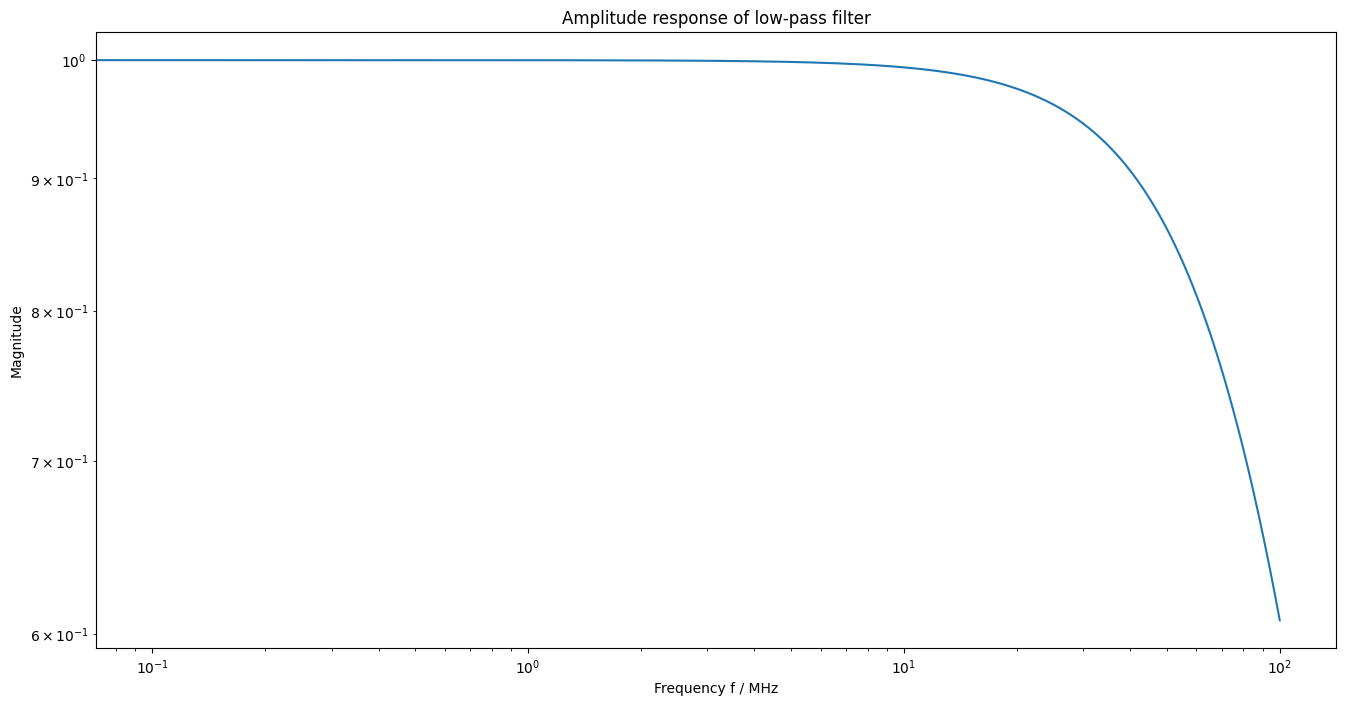

In [6]:
fc = 80e6  # cut of frequency (Hz) #default is 80 MHz

H_lowpass = lambda f: 1 / (1 + 1j * f / (fc * 1.555)) ** 2

fpl = np.linspace(0, 1e8, 1000)
figure(figsize=(16, 8))
loglog(fpl * 1e-6, np.abs(H_lowpass(fpl)))
plt.title("Amplitude response of low-pass filter")
plt.xlabel("Frequency f / MHz")
plt.ylabel("Magnitude")
show()

## Deconvolution and low-pass filtering

In [7]:
# prepare matrix-vector notation for DFT_deconv
H_RI = np.r_[hyd_interp["real"], hyd_interp["imag"]]
U_HRI = np.r_[
    np.c_[np.diag(hyd_interp["varreal"]), hyd_interp["cov"]],
    np.c_[hyd_interp["cov"], np.diag(hyd_interp["varimag"])],
]

# application of DFT_deconv
deconv = {"frequency": measurement_data["frequency"]}
deconv["P"], deconv["U_P"] = DFT_deconv(
    H_RI, measurement_data["spectrum"], U_HRI, measurement_data["varspec"]
)

# application of low-pass filter
N = len(deconv["frequency"]) // 2
H1 = H_lowpass(deconv["frequency"][:N])
Hl_RI = np.r_[np.real(H1), np.imag(H1)]
deconv["P"], deconv["U_P"] = DFT_multiply(deconv["P"], Hl_RI, deconv["U_P"])

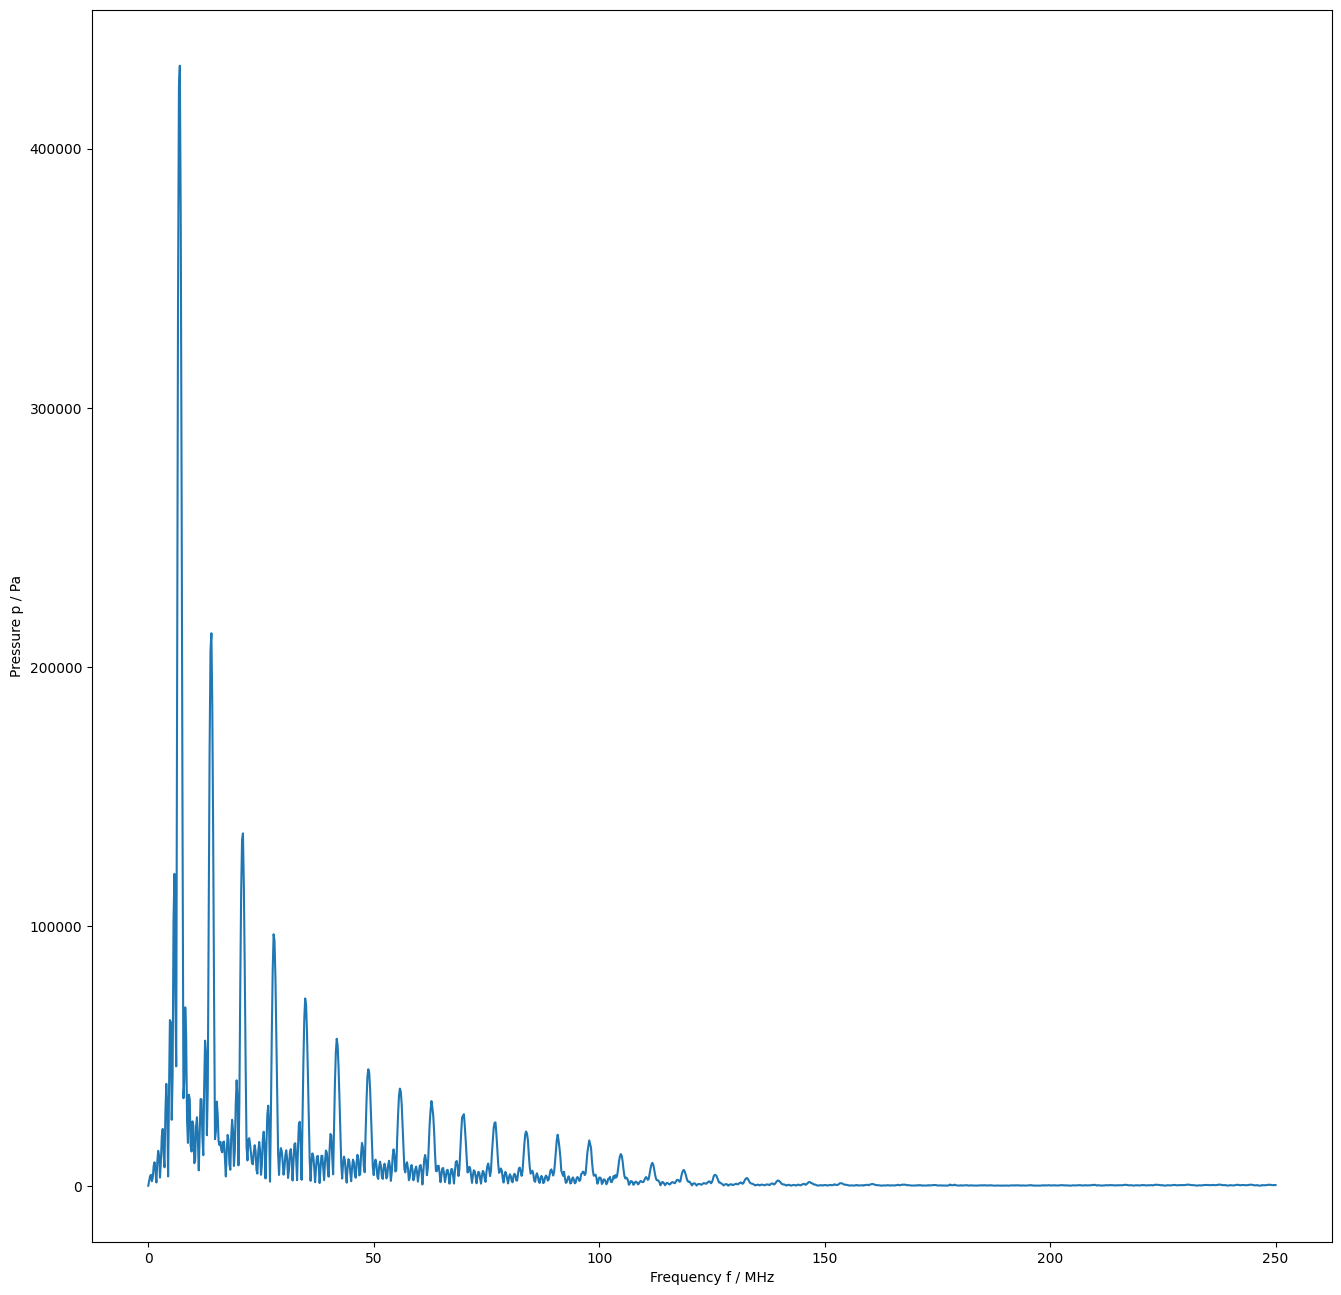

In [8]:
f = measurement_data["frequency"]
N = len(f) // 2
figure(figsize=(16, 16))
plot(f[:N] / 1e6, amplitude(deconv["P"]))
xlabel("Frequency f / MHz")
ylabel("Pressure p / Pa")
show()

## Estimation of regularization error

In [9]:
# calculate the average working frequency
f_awf = calc_awf(measurement_data["frequency"], measurement_data["spectrum"])

searching for f2 in interval [6.8,20] MHz
determined f1: 6.68571 MHz
determined f2: 19.5559 MHz
resulting f_awf = 13.12079550035726 MHz


In [10]:
def calculate_freq_points(fH, f, H, X, Fs, candidates, verbose=True):
    def get_candidates(f, S, number=40):
        # Largest local maxima of np.abs(S)
        inds = dsp.argrelmax(np.abs(S))[0]
        inds2 = inds[np.argsort(np.abs(S[inds]))[::-1]]
        return f[inds2[:number]], inds2[:number], np.abs(S[inds2[:number]])

    def get_closest(freqs, f_localmax):
        # Closest local maximum to selected frequency
        cfreqs = freqs.copy()
        for k in range(len(freqs)):
            indf = np.argmin(np.abs(f_localmax - freqs[k]))
            cfreqs[k] = f_localmax[indf]
        return cfreqs

    Ts = 1 / Fs
    f = np.fft.rfftfreq(Nf, Ts)

    Xh = X / H

    f_local = get_candidates(fH, np.abs(Xh))[0]
    frequencies = get_closest(candidates, f_local)

    return frequencies

In [11]:
# calculate center frequency candidates as multiples of fawf
multiples = [1, 3, 8]
fvals = [mult * f_awf for mult in multiples]

In [12]:
H = amplitude(np.r_[hyd_interp["real"], hyd_interp["imag"]])
M = amplitude(np.r_[measurement_data["spectrum"]])
Ts = measurement_data["time"][1] - measurement_data["time"][0]
Fs = 1 / Ts
N = len(measurement_data["frequency"]) // 2
# center_frequencies = calculate_freq_points(measurement_data["frequency"][:N],
#                                            H, N, Ts, Fs, fvals)

# figure(figsize=(16,8))
# plot(f, amplitude(measurement_data["spectrum"]))

In [13]:
# center_frequencies

In [14]:
fvals

[13120795.50035726, 39362386.50107178, 104966364.00285809]